<a href="https://www.kaggle.com/code/hannahkariuki/cnn-for-retinal-oct-images?scriptVersionId=127829182" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Convolutional Neural Networks for Classification of Retinal OCT Images

# Introduction
Retinal optical coherence tomography (OCT) is a non-invasive imaging technique used to capture high-resolution cross-sectional images of the retina at resolutions of a few microns, which allows for the visualization of individual retinal layers and structures. OCT is commonly used in the diagnosis and management of a range of retinal conditions, including macular degeneration, diabetic retinopathy, and glaucoma.

In this notebook, a custom CNN model is built for the classification of Retinal OCT images.

## Importing required libraries

In [1]:
# Imports
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Model, Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

In [2]:
# Reproducibility
import random
seed = 0
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

### Load Data

In [3]:
train_directory = '/kaggle/input/kermany2018/OCT2017 /train'
test_directory = '/kaggle/input/kermany2018/OCT2017 /test'

## Preprocessing
The grayscale images were converted to 'rgb', and resized to 128 by 128 pixels

In [4]:
train = tf.keras.preprocessing.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    seed=0,
    image_size=(128,128),
    batch_size=16,
    color_mode='rgb',
    validation_split= 0.2,
    subset='training'
)

validation = tf.keras.preprocessing.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    seed=0,
    image_size=(128,128),
    batch_size=16,
    color_mode='rgb',
    validation_split=0.2,
    subset='validation'
)

test = tf.keras.preprocessing.image_dataset_from_directory(
    test_directory,
    labels='inferred',
    image_size=(128,128),
    batch_size=16,
    color_mode='rgb',
)

Found 83484 files belonging to 4 classes.
Using 66788 files for training.
Found 83484 files belonging to 4 classes.
Using 16696 files for validation.
Found 968 files belonging to 4 classes.


In [5]:
class_labels= ['CNV', 'DME', 'DRUSEN', 'NORMAL']

In [6]:
#store test labels
test_labels = [labels for _, labels in test.unbatch()]

## Exploring the Data

Check the classes in the training set

In [7]:
# Classes
class_names=train.class_names
print(class_names)

['CNV', 'DME', 'DRUSEN', 'NORMAL']


Visualize the images

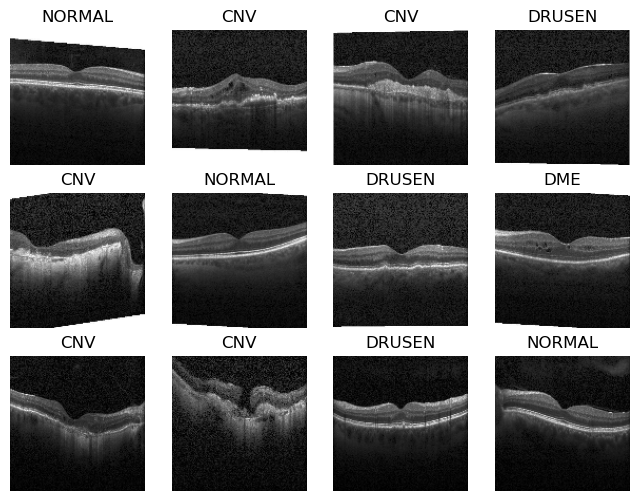

In [8]:
# visualize some of the images 
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
for images, labels in train.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [9]:
# Determine the distribution of classes
BATCH_SIZE=16
class_names = train.class_names

def class_distribution(dataset):
    class_values = []
    total_batches = dataset.__len__().numpy()
    for batch, element in enumerate(dataset.as_numpy_iterator()):
        if batch+1 == total_batches:
            for i in range(len(element[1])):
                class_values.append(class_names[int(element[1][i])])
        else:
            for i in range(BATCH_SIZE):
                class_values.append(class_names[int(element[1][i])])

    class_n, frequency = np.unique(np.array(class_values), return_counts=True)
    #frequency = frequency/len(class_values)
    return pd.DataFrame(frequency, class_n, columns=["Count"])

train_class_dist = class_distribution(train)
print(train_class_dist)

        Count
CNV     29709
DME      9113
DRUSEN   6917
NORMAL  21049


## Correct data imbalance
The dataset suffers class imbalance which is common in real-world scenarios. Most of the images are classified as CNV. The class imbalance can bias the model towards the majority class and lead to poor performance on the minority class. To address this issue,we calculate the weight for each class to be used in training step.


In [10]:
#Calculate class weight
total = len(train.file_paths)
count_cnv = 29709
count_dme = 9113
count_drusen = 6917
count_normal = 21049
cnv_weight = (1/count_cnv) * (total/4)
dme_weight = (1/count_dme) * (total/4)
drusen_weight = (1/count_drusen) * (total/4)
norm_weight = (1/count_normal) * (total/4)
class_weight = {0 : cnv_weight, 1: dme_weight, 2 : drusen_weight, 3: norm_weight}
print(class_weight)

{0: 0.5620182436298764, 1: 1.8322177109623616, 2: 2.413907763481278, 3: 0.7932443346477267}


In [11]:
# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float16)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
train = (
    train
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
validation = (
    validation
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
test = (
    test
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

## Define the Baseline Model

Baseline Model

In [12]:
model = tf.keras.Sequential([
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same',input_shape=(128,128,3)),
    layers.MaxPool2D(),
    
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),
    
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),
    
    layers.Conv2D(filters=512, kernel_size=3, activation='relu', padding='same'),
    layers.Conv2D(filters=512, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),
    
    layers.Flatten(),
    layers.Dense(16, activation='relu'),
    layers.Dense(units=4, activation='sigmoid'),
])

## Compile and Train the Model

In [13]:
optimizer=tf.keras.optimizers.experimental.SGD(learning_rate=0.0001)

In [14]:
model.compile(optimizer= optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    mode="min",
    restore_best_weights='True',
    min_delta=0.01)

history = model.fit(
    train,
    validation_data=validation,
    class_weight=class_weight,
    epochs= 20,
    shuffle=True,
)

Epoch 1/20
4175/4175 [==============================] - 276s 64ms/step - loss: 1.2082 - accuracy: 0.5413 - val_loss: 0.8821 - val_accuracy: 0.6695
Epoch 2/20
4175/4175 [==============================] - 86s 21ms/step - loss: 0.9316 - accuracy: 0.6868 - val_loss: 0.7007 - val_accuracy: 0.7388
Epoch 3/20
4175/4175 [==============================] - 86s 21ms/step - loss: 0.7685 - accuracy: 0.7483 - val_loss: 0.6419 - val_accuracy: 0.7538
Epoch 4/20
4175/4175 [==============================] - 85s 20ms/step - loss: 0.6721 - accuracy: 0.7790 - val_loss: 0.6101 - val_accuracy: 0.7665
Epoch 5/20
4175/4175 [==============================] - 86s 21ms/step - loss: 0.6107 - accuracy: 0.8007 - val_loss: 0.5955 - val_accuracy: 0.7732
Epoch 6/20
4175/4175 [==============================] - 86s 21ms/step - loss: 0.5640 - accuracy: 0.8169 - val_loss: 0.5741 - val_accuracy: 0.7786
Epoch 7/20
4175/4175 [==============================] - 85s 20ms/step - loss: 0.5234 - accuracy: 0.8289 - val_loss: 0.5608 

## Performancce Plot

Best Validation Loss: 0.3617
Best Validation Accuracy: 0.8743


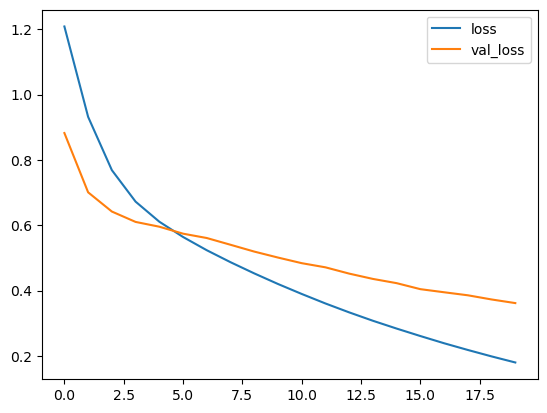

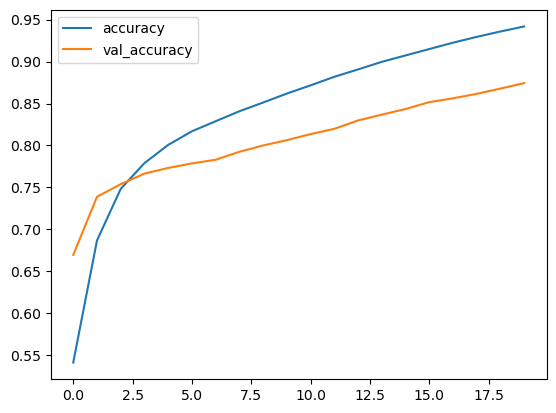

In [15]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()
print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_accuracy'].max()))

The model is overfitting. Various methods can be applied to correct overfitting; 
* Adding regularization layers(Dropout layer, BatchNormalization) 
* Data augmentation

## Define Model

In [16]:
#Adding Batch Normalization and Dropout
model = tf.keras.Sequential([
    layers.InputLayer(input_shape=[128, 128, 3]),
    
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),
    
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),
    
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),
    
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=512, kernel_size=3, activation='relu', padding='same'),
    layers.Conv2D(filters=512, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),
    
    layers.BatchNormalization(renorm=True),
    layers.Flatten(),
    layers.Dense(16, activation='relu'),
    layers.BatchNormalization(renorm=True),
    layers.Dropout(0.3),
    layers.Dense(units=4, activation='sigmoid'),
])

## Compile and Train Model

In [17]:
optimizer=tf.keras.optimizers.experimental.SGD(learning_rate=0.0001)

In [18]:
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    mode="min",
    restore_best_weights='True',
    min_delta=0.01)

history = model.fit(
    train,
    validation_data=validation,
    class_weight=class_weight,
    epochs= 20,
    callbacks=[early_stopping],
    shuffle=True,
)

Epoch 1/20
4175/4175 [==============================] - 117s 27ms/step - loss: 1.2776 - accuracy: 0.5390 - val_loss: 0.6964 - val_accuracy: 0.7389
Epoch 2/20
4175/4175 [==============================] - 113s 27ms/step - loss: 0.7714 - accuracy: 0.7241 - val_loss: 0.5625 - val_accuracy: 0.8000
Epoch 3/20
4175/4175 [==============================] - 113s 27ms/step - loss: 0.5904 - accuracy: 0.7883 - val_loss: 0.4929 - val_accuracy: 0.8233
Epoch 4/20
4175/4175 [==============================] - 114s 27ms/step - loss: 0.4815 - accuracy: 0.8267 - val_loss: 0.4417 - val_accuracy: 0.8479
Epoch 5/20
4175/4175 [==============================] - 114s 27ms/step - loss: 0.4115 - accuracy: 0.8533 - val_loss: 0.4242 - val_accuracy: 0.8511
Epoch 6/20
4175/4175 [==============================] - 116s 28ms/step - loss: 0.3568 - accuracy: 0.8736 - val_loss: 0.3912 - val_accuracy: 0.8681
Epoch 7/20
4175/4175 [==============================] - 113s 27ms/step - loss: 0.3126 - accuracy: 0.8914 - val_loss: 0

## Performance Plot

Best Validation Loss: 0.2670
Best Validation Accuracy: 0.9152


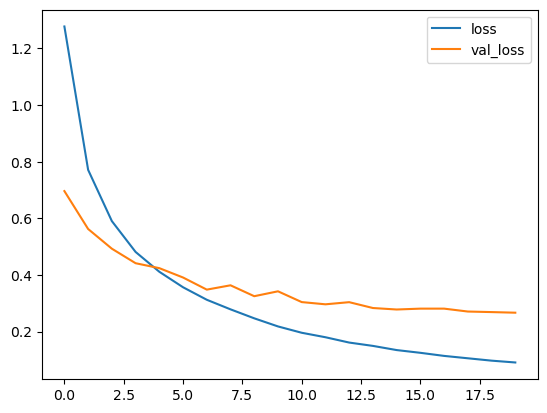

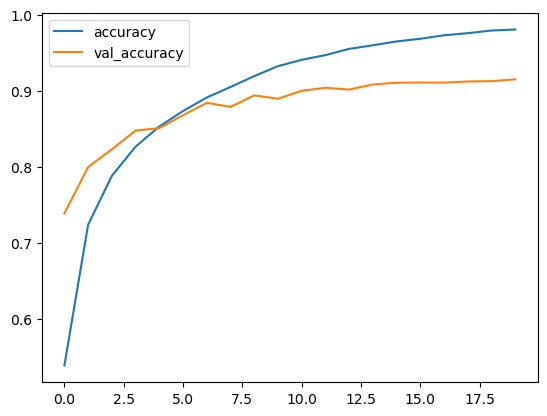

In [19]:
acc = history.history['accuracy']
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()
print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_accuracy'].max()))

## Predict and Evaluate Results

In [20]:
model.evaluate(test, return_dict=True)

61/61 [==============================] - 4s 63ms/step - loss: 0.0649 - accuracy: 0.9814


{'loss': 0.06492693722248077, 'accuracy': 0.9814049601554871}

In [21]:
predictions = model.predict(test)
#Convert prediction probabilities into integers
predictions = np.argmax(predictions, axis=1)

61/61 [==============================] - 1s 7ms/step


In [22]:

#get classification report
print(classification_report(predictions, test_labels, target_names=class_labels))

              precision    recall  f1-score   support

         CNV       0.22      0.22      0.22       248
         DME       0.23      0.24      0.23       235
      DRUSEN       0.27      0.28      0.27       239
      NORMAL       0.26      0.25      0.25       246

    accuracy                           0.25       968
   macro avg       0.25      0.25      0.25       968
weighted avg       0.25      0.25      0.25       968



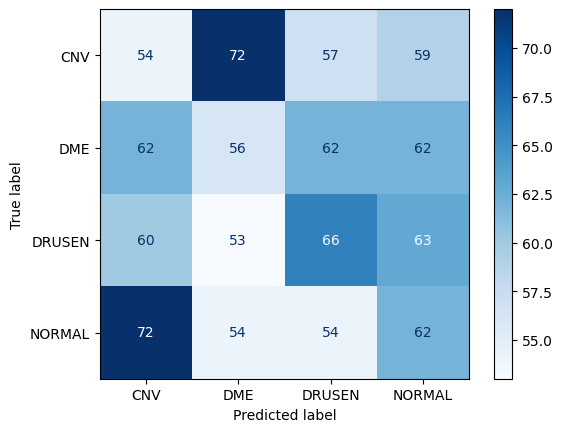

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(test_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()

## Conclusion
Custom CNN was developed to classify Retinal OCT images. The performance of the model was not the best. Next steps

* Hyperparameter tuning
* Data Augmentation
* Transfer Learning